In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Column labels

DATE = 'Date'
TERM = 'Term'
COUPON = 'Coupon'
NAME = 'Name'
ISIN = 'ISIN'
ISSUE_DATE = 'Issue Date'
MATURITY_DATE = 'Maturity Date'
CLOSE_PRICE = 'Close Price (% of par)'

raw_df = pd.read_csv("bonds_master_all.csv")

print("Shape of raw data:", raw_df.shape)
print("\nColumns in raw data:")
print(raw_df.columns.tolist())

raw_df.head()


# Global bond settings

FACE = 100.0
FREQ = 2 

# Toggle this depending on your data source:
# True  -> CLOSE_PRICE is a CLEAN quote (common), so dirty = clean + accrued
# False -> CLOSE_PRICE already equals DIRTY price, so dirty = close price
ASSUME_CLOSE_IS_CLEAN = True

Shape of raw data: (462, 26)

Columns in raw data:
['Term', 'bond_page_url', 'tkData', 'chart_json_url', 'ISIN', 'Name', 'Country', 'Issuer', 'Issue Volume', 'Currency', 'Issue Price', 'Issue Date', 'Coupon', 'Denomination', 'Quotation Type', 'Payment Type', 'Special Coupon Type', 'Maturity Date', 'Coupon Payment Date', 'Payment Frequency', 'No. of Payments per Year', 'Coupon Start Date', 'Final Coupon Date', 'Floater?', 'date', 'Close Price (% of par)']


In [60]:
# Data cleaning: build df_required (ONLY keep required columns)
#    - rename date -> Date
#    - convert dates to datetime
#    - standardize NAME to: "CAN {coupon} {Mon} {yy}"

# Select columns (note: your raw uses 'date' lower-case)
df_required = raw_df[['date', TERM, COUPON, NAME, ISIN, ISSUE_DATE, MATURITY_DATE, CLOSE_PRICE]].copy()
df_required = df_required.rename(columns={'date': DATE})

# Convert to datetime
df_required[DATE] = pd.to_datetime(df_required[DATE])
df_required[ISSUE_DATE] = pd.to_datetime(df_required[ISSUE_DATE])
df_required[MATURITY_DATE] = pd.to_datetime(df_required[MATURITY_DATE])

# Coupon string -> numeric -> nicer string
coupon_num = df_required[COUPON].astype(str).str.replace('%', '', regex=False).astype(float)
coupon_str = coupon_num.map(lambda x: f"{x:g}")  # remove trailing zeros

# Build NAME: CAN {coupon} {Mon} {yy}
mon = df_required[MATURITY_DATE].dt.strftime('%b')
yy = df_required[MATURITY_DATE].dt.strftime('%y')
df_required[NAME] = "CAN " + coupon_str + " " + mon + " " + yy

df_required.head()

,Date,Term,Coupon,Name,ISIN,Issue Date,Maturity Date,Close Price (% of par)
0,2026-01-05,Short-term,4.500%,CAN 4.5 Feb 26,CA135087R226,2023-11-01,2026-02-01,100.14
1,2026-01-06,Short-term,4.500%,CAN 4.5 Feb 26,CA135087R226,2023-11-01,2026-02-01,100.13
2,2026-01-07,Short-term,4.500%,CAN 4.5 Feb 26,CA135087R226,2023-11-01,2026-02-01,100.13
3,2026-01-08,Short-term,4.500%,CAN 4.5 Feb 26,CA135087R226,2023-11-01,2026-02-01,100.12
4,2026-01-09,Short-term,4.500%,CAN 4.5 Feb 26,CA135087R226,2023-11-01,2026-02-01,100.11


In [61]:
# Q2: Select the final 10 bonds from df_required

selected_bond_names = [
    "CAN 1.5 Jun 26",
    "CAN 3.25 Nov 26",
    "CAN 2.75 May 27",
    "CAN 2.25 Feb 28",
    "CAN 2 Jun 28",
    "CAN 4 Mar 29",
    "CAN 3.5 Sep 29",
    "CAN 2.75 Mar 30",
    "CAN 2.75 Sep 30",
    "CAN 2.75 Mar 31",
]

df_10 = df_required[df_required[NAME].isin(selected_bond_names)].copy()

# sanity checks
print("Number of selected bonds (unique names):", df_10[NAME].nunique())
print("Number of selected bonds (unique ISINs):", df_10[ISIN].nunique())
print("Number of trading days:", df_10[DATE].nunique())

# out_file = "selected_bonds_10.xlsx"
# df_10.to_excel(out_file, sheet_name="selected_10", index=False)

Number of selected bonds (unique names): 10
Number of selected bonds (unique ISINs): 10
Number of trading days: 11


In [62]:
#4a
# Using DIRTY price = CLEAN price + Accrued Interest
# Using "Mathematical convention": continuous compounding

#  Build df_final: add a "Target Term" column (your fixed mapping)
#  (Each bond represents a specific time period for plotting)

term_map = {
    "CAN 1.5 Jun 26": 0.5,
    "CAN 3.25 Nov 26": 1.0,
    "CAN 2.75 May 27": 1.5,
    "CAN 2.25 Feb 28": 2.0,
    "CAN 2 Jun 28": 2.5,
    "CAN 4 Mar 29": 3.0,
    "CAN 3.5 Sep 29": 3.5,
    "CAN 2.75 Mar 30": 4.0,
    "CAN 2.75 Sep 30": 4.5,
    "CAN 2.75 Mar 31": 5.0,
}

df_final = df_10.copy()
df_final['Target Term (Years)'] = df_final[NAME].map(term_map)

# Basic checks
df_final = df_final.sort_values([DATE, 'Target Term (Years)']).reset_index(drop=True)


# Helper functions: coupon schedule, accrued interest, and YTM solver

def _add_months(dt: pd.Timestamp, months: int) -> pd.Timestamp:
    """Return dt shifted by `months` months (keeps day-of-month as best as possible)."""
    return dt + pd.DateOffset(months=months)

def build_coupon_schedule(issue_dt: pd.Timestamp,
                          maturity_dt: pd.Timestamp,
                          freq: int = 2) -> list[pd.Timestamp]:
    """
    Build the full coupon payment date schedule from issue to maturity (inclusive).
    GoC: semi-annual => step = 6 months.
    """
    step_months = 12 // freq

    # Build backwards from maturity to avoid "first coupon date" ambiguity
    dates = [maturity_dt]
    cur = maturity_dt

    # Go backwards in 6-month steps until we go before issue date
    while True:
        nxt = _add_months(cur, -step_months)
        if nxt < issue_dt:
            break
        dates.append(nxt)
        cur = nxt

    dates = sorted(dates)

    # Ensure maturity included
    if dates[-1] != maturity_dt:
        dates.append(maturity_dt)

    return dates

def get_last_next_coupon(obs_dt: pd.Timestamp,
                         schedule: list[pd.Timestamp],
                         issue_dt: pd.Timestamp) -> tuple[pd.Timestamp, pd.Timestamp]:
    """
    Given an observation date, return (last_coupon_date, next_coupon_date).
    If obs_dt is before the first coupon date in schedule, treat last = issue_dt.
    """
    future = [d for d in schedule if d > obs_dt]
    past = [d for d in schedule if d <= obs_dt]

    if len(future) == 0:
        # Observing on/after maturity: next not meaningful, but handle gracefully
        return (schedule[-1], schedule[-1])

    next_cpn = future[0]
    last_cpn = past[-1] if len(past) > 0 else issue_dt
    return (last_cpn, next_cpn)

def accrued_interest(obs_dt: pd.Timestamp,
                     issue_dt: pd.Timestamp,
                     maturity_dt: pd.Timestamp,
                     coupon_rate_pct: float,
                     face: float = 100.0,
                     freq: int = 2) -> float:
    """
    Accrued Interest (AI) for a coupon bond using:
        AI = coupon_per_period * (days_since_last_coupon / days_in_coupon_period)
    """
    schedule = build_coupon_schedule(issue_dt, maturity_dt, freq=freq)
    last_cpn, next_cpn = get_last_next_coupon(obs_dt, schedule, issue_dt)

    coupon_per_period = face * (coupon_rate_pct / 100.0) / freq

    # Day count (Assignment hint allows simplifications; we use actual days here)
    d = (obs_dt - last_cpn).days
    D = (next_cpn - last_cpn).days

    # If we are exactly on coupon date, d=0 => AI=0
    if D <= 0:
        return 0.0

    frac = max(0.0, min(1.0, d / D))
    return coupon_per_period * frac

def bond_cashflows_after(obs_dt: pd.Timestamp,
                         issue_dt: pd.Timestamp,
                         maturity_dt: pd.Timestamp,
                         coupon_rate_pct: float,
                         face: float = 100.0,
                         freq: int = 2) -> tuple[np.ndarray, np.ndarray]:
    """
    Return (t_i, CF_i) arrays for cashflows strictly AFTER obs_dt:
        PV = sum_i CF_i * exp(-y * t_i)   (continuous compounding)
    where t_i is in years (days/365).
    """
    schedule = build_coupon_schedule(issue_dt, maturity_dt, freq=freq)
    pay_dates = [d for d in schedule if d > obs_dt]

    coupon_per_period = face * (coupon_rate_pct / 100.0) / freq

    cfs = []
    ts = []
    for d in pay_dates:
        cf = coupon_per_period
        if d == maturity_dt:
            cf += face  # principal at maturity
        t = (d - obs_dt).days / 365.0  # year fraction (simple convention)
        cfs.append(cf)
        ts.append(t)

    return np.array(ts, dtype=float), np.array(cfs, dtype=float)

def pv_continuous(y: float, t: np.ndarray, cf: np.ndarray) -> float:
    """Present value under continuous compounding."""
    return float(np.sum(cf * np.exp(-y * t)))

def solve_ytm_continuous(price_dirty: float,
                         t: np.ndarray,
                         cf: np.ndarray,
                         y_low: float = -0.05,
                         y_high: float = 0.30,
                         tol: float = 1e-10,
                         max_iter: int = 200) -> float:
    """
    Solve for YTM y in:
        price_dirty = sum CF_i * exp(-y * t_i)
    using a robust bisection method (no SciPy needed).
    """
    def f(y: float) -> float:
        return pv_continuous(y, t, cf) - price_dirty

    lo, hi = y_low, y_high
    flo, fhi = f(lo), f(hi)

    # Expand bracket if needed
    expand_count = 0
    while flo * fhi > 0 and expand_count < 30:
        # If PV(hi) still > price, increase hi; otherwise decrease lo
        if fhi > 0:
            hi += 0.10
        else:
            lo -= 0.10
        flo, fhi = f(lo), f(hi)
        expand_count += 1

    if flo * fhi > 0:
        # If still no sign change, return NaN (data issue)
        return np.nan

    # Bisection
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if abs(fmid) < tol:
            return mid
        if flo * fmid > 0:
            lo, flo = mid, fmid
        else:
            hi, fhi = mid, fmid

    return 0.5 * (lo + hi)


# Compute Dirty Price and YTM for each (bond, day) row

ytm_list = []
dirty_list = []
ai_list = []

for _, row in df_final.iterrows():
    obs_dt = row[DATE]
    issue_dt = row[ISSUE_DATE]
    maturity_dt = row[MATURITY_DATE]

    # Coupon rate could be stored as numeric already; if it's string like "2.5%", strip it.
    coupon_raw = getattr(row, COUPON)
    if isinstance(coupon_raw, str):
        coupon_rate_pct = float(coupon_raw.replace('%', '').strip())
    else:
        coupon_rate_pct = float(coupon_raw)

    clean_price = float(getattr(row, CLOSE_PRICE))  # per 100 par (e.g., 98.25)

    # Accrued Interest
    ai = accrued_interest(
        obs_dt=obs_dt,
        issue_dt=issue_dt,
        maturity_dt=maturity_dt,
        coupon_rate_pct=coupon_rate_pct,
        face=FACE,
        freq=FREQ
    )

    # Dirty Price
    if ASSUME_CLOSE_IS_CLEAN:
        price_dirty = clean_price + ai
    else:
        price_dirty = clean_price

    # Cashflows and YTM (continuous)
    t_i, cf_i = bond_cashflows_after(
        obs_dt=obs_dt,
        issue_dt=issue_dt,
        maturity_dt=maturity_dt,
        coupon_rate_pct=coupon_rate_pct,
        face=FACE,
        freq=FREQ
    )

    ytm = solve_ytm_continuous(price_dirty=price_dirty, t=t_i, cf=cf_i)*100

    ai_list.append(ai)
    dirty_list.append(price_dirty)
    ytm_list.append(ytm)

df_final['Accrued Interest'] = ai_list
df_final['Dirty Price'] = dirty_list
df_final['YTM (cont. comp)'] = ytm_list

# Quick check print
print(df_final[[DATE, NAME, 'Target Term (Years)', CLOSE_PRICE, 'Accrued Interest', 'Dirty Price', 'YTM (cont. comp)']].head(15))

         Date             Name  Target Term (Years)  Close Price (% of par)  \
0  2026-01-05   CAN 1.5 Jun 26                  0.5                  99.680   
1  2026-01-05  CAN 3.25 Nov 26                  1.0                 100.690   
2  2026-01-05  CAN 2.75 May 27                  1.5                 100.325   
3  2026-01-05  CAN 2.25 Feb 28                  2.0                  99.239   
4  2026-01-05     CAN 2 Jun 28                  2.5                  98.550   
5  2026-01-05     CAN 4 Mar 29                  3.0                 103.630   
6  2026-01-05   CAN 3.5 Sep 29                  3.5                 102.220   
7  2026-01-05  CAN 2.75 Mar 30                  4.0                  99.493   
8  2026-01-05  CAN 2.75 Sep 30                  4.5                  99.165   
9  2026-01-05  CAN 2.75 Mar 31                  5.0                  98.813   
10 2026-01-06   CAN 1.5 Jun 26                  0.5                  99.690   
11 2026-01-06  CAN 3.25 Nov 26                  1.0 

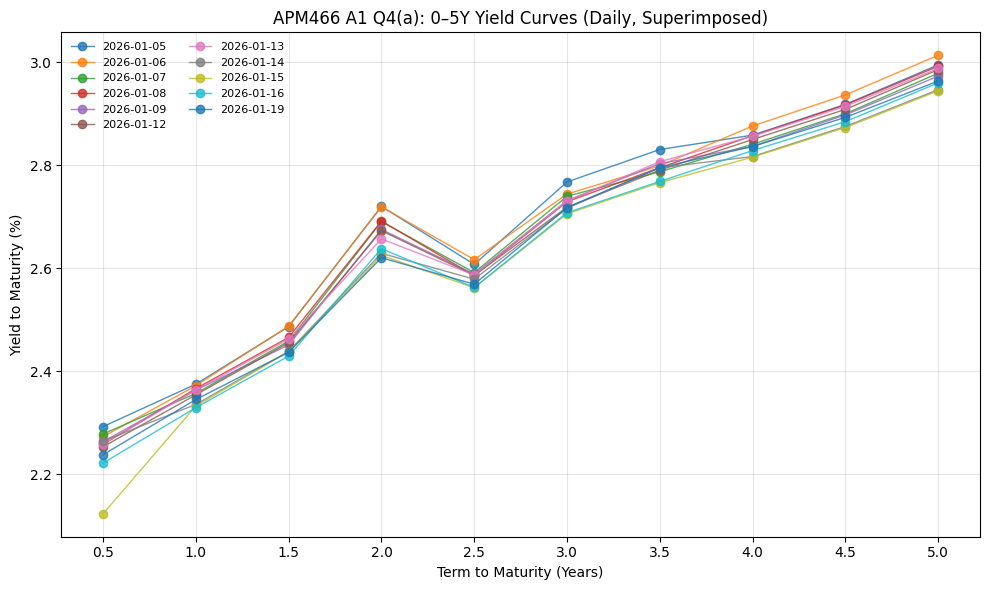

In [63]:

# Plot: 0–5 Year YTM curves for each day

plt.figure(figsize=(10, 6))

for d, grp in df_final.groupby(DATE):
    grp = grp.sort_values('Target Term (Years)')
    x = grp['Target Term (Years)'].to_numpy()
    y = grp['YTM (cont. comp)'].to_numpy()
    plt.plot(x, y, marker='o', linewidth=1, alpha=0.8, label=str(d.date()))

plt.xlabel('Term to Maturity (Years)')
plt.ylabel('Yield to Maturity (%)')
plt.title('APM466 A1 Q4(a): 0–5Y Yield Curves (Daily, Superimposed)')
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.grid(True, alpha=0.3)

# If too many dates, comment out legend or make it smaller
plt.legend(fontsize=8, ncol=2, frameon=False)

plt.tight_layout()
plt.show()


In [64]:
# 4b
# Standardize coupon: "2.5%" -> 2.5
df_final['Coupon_pct'] = (
    df_final['Coupon']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float)
)

# Semi-annual coupon amount
df_final['Coupon_amt'] = FACE * df_final['Coupon_pct'] / 100 / FREQ

def bootstrap_spot_curve_one_day(df_day):
    """
    Bootstrap spot rates for ONE observation date using hint method.
    Continuous compounding version of:

        P = sum_{t < T} C * exp(-S(t) * t) + (C + F) * exp(-S(T) * T)

    Returns: DataFrame with Target Term and Spot Rate
    """

    df_day = df_day.sort_values('Target Term (Years)').copy()

    spot_rates = {}  # dictionary: maturity -> spot rate

    for _, row in df_day.iterrows():

        T = row['Target Term (Years)']
        P = row['Dirty Price']
        C = row['Coupon_amt']

        # ----------------------------------------
        # Step 1: Present value of earlier coupons
        # ----------------------------------------
        pv_known = 0.0

        for t_prev, S_prev in spot_rates.items():
            pv_known += C * np.exp(-S_prev * t_prev)

        # ----------------------------------------
        # Step 2: Solve for S(T)
        # P - PV_known = (C + F) * exp(-S(T) * T)
        # ----------------------------------------
        remaining = P - pv_known

        if remaining <= 0:
            raise ValueError(
                f"Negative remaining PV at T={T}. "
                "Check data or coupon schedule."
            )

        S_T = - (1.0 / T) * np.log(remaining / (FACE + C))

        spot_rates[T] = S_T

    return pd.DataFrame({
        'Target Term (Years)': list(spot_rates.keys()),
        'Spot Rate': list(spot_rates.values())
    })

# iterate bootstrapping for every day
spot_curve_list = []

for date, df_day in df_final.groupby('Date'):
    spot_df = bootstrap_spot_curve_one_day(df_day)
    spot_df['Date'] = date
    spot_curve_list.append(spot_df)

spot_df_all = pd.concat(spot_curve_list, ignore_index=True)

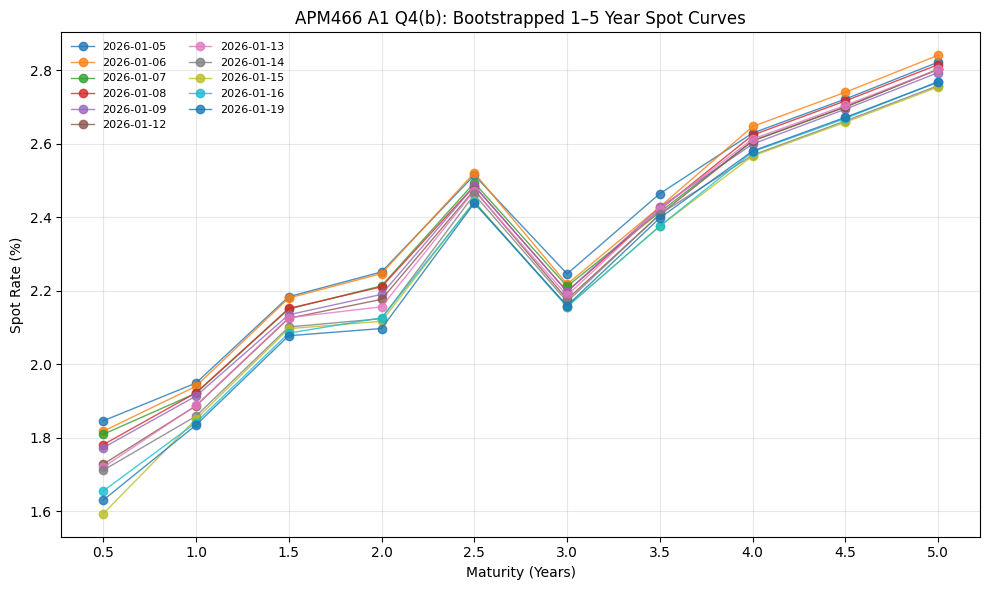

In [65]:
plt.figure(figsize=(10, 6))

for date, grp in spot_df_all.groupby('Date'):
    grp = grp.sort_values('Target Term (Years)')
    plt.plot(
        grp['Target Term (Years)'],
        grp['Spot Rate'] * 100,   # <-- 这里乘 100
        marker='o',
        linewidth=1,
        alpha=0.8,
        label=str(date.date())
    )

plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('APM466 A1 Q4(b): Bootstrapped 1–5 Year Spot Curves')
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, ncol=2, frameon=False)

plt.tight_layout()
plt.show()

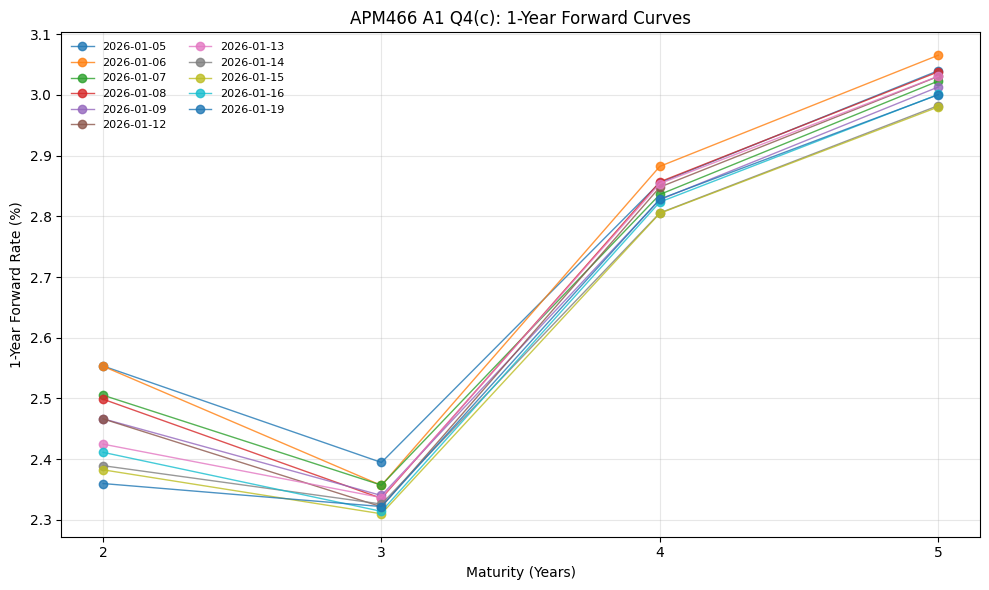

In [66]:
# 4c

# date forward curve
forward_curves = []

for date, grp in spot_df_all.groupby('Date'):

    # Create a dictionary: maturity -> spot rate
    S = dict(zip(grp['Target Term (Years)'], grp['Spot Rate']))

    # Use t = 1 as the fixed start
    S1 = S[1.0]

    for end in [2.0, 3.0, 4.0, 5.0]:
        n = end - 1.0
        fwd = (S[end] * end - S1 * 1.0) / n

        forward_curves.append({
            'Date': date,
            'Forward Maturity': end,
            'Forward Rate': fwd
        })

forward_df = pd.DataFrame(forward_curves)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for date, grp in forward_df.groupby('Date'):
    grp = grp.sort_values('Forward Maturity')
    plt.plot(
        grp['Forward Maturity'],
        grp['Forward Rate'] * 100,   # convert to %
        marker='o',
        linewidth=1,
        alpha=0.8,
        label=str(date.date())
    )

plt.xlabel('Maturity (Years)')
plt.ylabel('1-Year Forward Rate (%)')
plt.title('APM466 A1 Q4(c): 1-Year Forward Curves')
plt.xticks([2, 3, 4, 5])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [67]:
#5
# yield
yield_wide = (
    df_final
    .pivot(index='Date',
           columns='Target Term (Years)',
           values='YTM (cont. comp)')
    .sort_index()
)

yield_wide = yield_wide[[1, 2, 3, 4, 5]]

yield_log_returns = np.log(yield_wide.shift(-1) / yield_wide)
yield_log_returns = yield_log_returns.iloc[:-1]  # 去掉最后一行 NaN

cov_yield = np.cov(yield_log_returns.T, bias=False)

cov_yield_df = pd.DataFrame(
    cov_yield,
    index=yield_log_returns.columns,
    columns=yield_log_returns.columns
)

print("Covariance matrix of yield log-returns:")
display(cov_yield_df)

Covariance matrix of yield log-returns:


Target Term (Years),1.0,2.0,3.0,4.0,5.0
Target Term (Years),,,,,
1.0,0.000030,0.000010,1.184160e-05,2.940988e-05,0.000026
2.0,0.000010,0.000026,-4.122169e-06,3.137777e-05,0.000031
3.0,0.000012,-0.000004,1.725271e-05,-2.324521e-07,-0.000001
4.0,0.000029,0.000031,-2.324521e-07,5.835004e-05,0.000054
5.0,0.000026,0.000031,-1.152442e-06,5.448451e-05,0.000052


In [68]:
#5
#forward

forward_wide = (
    forward_df
    .pivot(index='Date', columns='Forward Maturity', values='Forward Rate')
    .sort_index()
)

# 顺序固定为 2–5 年
forward_wide = forward_wide[[2, 3, 4, 5]]

forward_log_returns = np.log(forward_wide.shift(-1) / forward_wide)
forward_log_returns = forward_log_returns.iloc[:-1]

cov_forward = np.cov(forward_log_returns.T, bias=False)

cov_forward_df = pd.DataFrame(
    cov_forward,
    index=forward_log_returns.columns,
    columns=forward_log_returns.columns
)

print("Covariance matrix of forward-rate log-returns:")
display(cov_forward_df)

Covariance matrix of forward-rate log-returns:


Forward Maturity,2.0,3.0,4.0,5.0
Forward Maturity,,,,
2.0,0.000115,-0.000036,0.000067,0.000064
3.0,-0.000036,0.000049,-0.000024,-0.000022
4.0,0.000067,-0.000024,0.000100,0.000086
5.0,0.000064,-0.000022,0.000086,0.000076


In [69]:
# 6
# Helper: eigendecomposition， sorting (largest eigenvalue first)

def eig_sorted(cov_df: pd.DataFrame):
    """
    Input:  cov_df as a labeled covariance DataFrame (symmetric)
    Output: (eigvals_sorted, eigvecs_sorted_df)
            - eigvals_sorted: 1D numpy array (descending)
            - eigvecs_sorted_df: DataFrame, columns are PC1, PC2, ...
              rows are the original variable labels (maturities)
    """
    A = cov_df.values.astype(float)

    # For symmetric matrices, eigh is numerically stable
    eigvals, eigvecs = np.linalg.eigh(A)  # ascending order by default

    # Sort descending (largest first)
    idx = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]

    # Put eigenvectors into a labeled DataFrame
    pc_cols = [f"PC{i+1}" for i in range(eigvecs_sorted.shape[1])]
    eigvecs_sorted_df = pd.DataFrame(
        eigvecs_sorted,
        index=cov_df.index,
        columns=pc_cols
    )

    return eigvals_sorted, eigvecs_sorted_df

In [70]:
# Yield covariance: eigenvalues & eigenvectors

eigvals_yield, eigvecs_yield = eig_sorted(cov_yield_df)

eigvals_yield_df = pd.DataFrame({
    "Eigenvalue": eigvals_yield,
    "Explained Var Ratio": eigvals_yield / eigvals_yield.sum()
}, index=[f"PC{i+1}" for i in range(len(eigvals_yield))])

print("Yield Covariance Matrix: Eigenvalues")
display(eigvals_yield_df)

print("\n Yield Covariance Matrix: Eigenvectors")
display(eigvecs_yield)

# Forward covariance: eigenvalues & eigenvectors
eigvals_fwd, eigvecs_fwd = eig_sorted(cov_forward_df)

eigvals_fwd_df = pd.DataFrame({
    "Eigenvalue": eigvals_fwd,
    "Explained Var Ratio": eigvals_fwd / eigvals_fwd.sum()
}, index=[f"PC{i+1}" for i in range(len(eigvals_fwd))])

print("Forward Covariance Matrix: Eigenvalues")
display(eigvals_fwd_df)

print("\n Forward Covariance Matrix: Eigenvectors (columns=PCs)")
display(eigvecs_fwd)


Yield Covariance Matrix: Eigenvalues


,Eigenvalue,Explained Var Ratio
PC1,1.426010e-04,0.781980
PC2,3.046251e-05,0.167047
PC3,6.848955e-06,0.037558
PC4,2.303655e-06,0.012633
PC5,1.428364e-07,0.000783



 Yield Covariance Matrix: Eigenvectors


,PC1,PC2,PC3,PC4,PC5
Target Term (Years),,,,,
1.0,-0.334119,0.629304,-0.315198,0.625974,0.033884
2.0,-0.356635,-0.348799,0.684991,0.512691,-0.138150
3.0,-0.013165,0.683701,0.622695,-0.380008,-0.014950
4.0,-0.635732,-0.041485,-0.207440,-0.367150,-0.645208
5.0,-0.597367,-0.114663,-0.025611,-0.257097,0.750499


Forward Covariance Matrix: Eigenvalues


,Eigenvalue,Explained Var Ratio
PC1,2.531939e-04,0.747003
PC2,5.340380e-05,0.157558
PC3,3.206908e-05,0.094614
PC4,2.793768e-07,0.000824



 Forward Covariance Matrix: Eigenvectors (columns=PCs)


,PC1,PC2,PC3,PC4
Forward Maturity,,,,
2.0,-0.581302,0.618040,-0.524334,-0.072026
3.0,0.225818,-0.499502,-0.836069,-0.022225
4.0,-0.582825,-0.491629,0.153013,-0.628652
5.0,-0.520970,-0.356126,0.051477,0.774025
